In [1]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.io import arff
import torch
from torch.utils.data import TensorDataset, DataLoader

# Directory where datasets will be downloaded and extracted
DATA_DIR = 'datasets'
os.makedirs(DATA_DIR, exist_ok=True)


def download_dataset(dataset_name, url):
    """
    Downloads and extracts a zip file containing the dataset.
    """
    zip_path = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_path = os.path.join(DATA_DIR, dataset_name)

    # Download the dataset
    print(f"Downloading {dataset_name} from {url}...")
    urllib.request.urlretrieve(url, zip_path)

    # Extract the zip file
    print(f"Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"Dataset {dataset_name} extracted to {extract_path}.")
    return extract_path

def load_arff_data(file_path):
    """
    Loads ARFF file and converts it to a pandas DataFrame.
    """
    print(f"Loading ARFF file: {file_path}")
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    return df

def preprocess_data(train_df, test_df, batch_size=64):
    """
    Preprocesses the data:
    - Splits the features and labels.
    - Normalizes the features.
    - Converts them into PyTorch tensors.
    - Creates DataLoaders for training, validation, and testing.
    """
    # Separate features and labels
    train_features = train_df.drop(columns=['class'])  # Assuming 'class' is the label column
    test_features = test_df.drop(columns=['class'])

    # Adjust labels to start from 0
    train_labels = train_df['class'].apply(lambda x: int(x) - 1).values
    test_labels = test_df['class'].apply(lambda x: int(x) - 1).values

    # Normalize features
    scaler = StandardScaler()
    train_features_normalized = scaler.fit_transform(train_features)
    test_features_normalized = scaler.transform(test_features)

    # Reshape the features into 3D arrays (samples, time_steps, dimensions)
    X_train = train_features_normalized.reshape(-1, 60, 1)  # Adjust time_steps to 60
    X_test = test_features_normalized.reshape(-1, 60, 1)

    # Split test data into validation and test sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, test_labels, test_size=0.50, random_state=42)

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(train_labels, dtype=torch.int64)

    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    # Output dataset shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Return both the DataLoaders and the raw tensors
    return train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test

# Example usage for downloading, extracting, and preprocessing the SharePriceIncrease dataset
if __name__ == "__main__":
    # URL for the dataset (replace with the actual dataset you want to download)
    dataset_name = 'SharePriceIncrease'
    dataset_url = 'https://timeseriesclassification.com/aeon-toolkit/SharePriceIncrease.zip'
    extract_path = download_dataset(dataset_name, dataset_url)

    # Load ARFF data
    train_file = os.path.join(extract_path, f'{dataset_name}_TRAIN.arff')
    test_file = os.path.join(extract_path, f'{dataset_name}_TEST.arff')

    # Load data into Pandas DataFrames
    train_df = load_arff_data(train_file)
    test_df = load_arff_data(test_file)

    # Preprocess the data
    train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test = preprocess_data(train_df, test_df)

    n_classes = len(torch.unique(y_train))

    # Output the number of classes
    print(f"Number of classes: {n_classes}")


'''
# Example usage
if __name__ == '__main__':
    ds_name = 'SharePriceIncrease'
    url = 'https://timeseriesclassification.com/aeon-toolkit/SharePriceIncrease.zip'
    path = download_dataset(ds_name, url)
    train_arff = [os.path.join(path, f'{ds_name}Dimension{i+1}_TRAIN.arff') for i in range(6)]
    test_arff  = [os.path.join(path, f'{ds_name}Dimension{i+1}_TEST.arff')  for i in range(6)]

    X_train_df, y_train_srs, X_valid_df, y_valid_srs, X_test_df, y_test_srs = \
        preprocess_data_df(train_arff, test_arff)

    print('Shapes:', X_train_df.shape, y_train_srs.shape,
          X_valid_df.shape, y_valid_srs.shape,
          X_test_df.shape,  y_test_srs.shape)'''

Extracting SharePriceIncrease...
Dataset SharePriceIncrease extracted to datasets\SharePriceIncrease.
Loading ARFF file: datasets\SharePriceIncrease\SharePriceIncrease_TRAIN.arff
Loading ARFF file: datasets\SharePriceIncrease\SharePriceIncrease_TEST.arff
X_train shape: torch.Size([965, 60, 1]), y_train shape: torch.Size([965])
X_valid shape: torch.Size([483, 60, 1]), y_valid shape: torch.Size([483])
X_test shape: torch.Size([483, 60, 1]), y_test shape: torch.Size([483])
Number of classes: 2


"\n# Example usage\nif __name__ == '__main__':\n    ds_name = 'SharePriceIncrease'\n    url = 'https://timeseriesclassification.com/aeon-toolkit/SharePriceIncrease.zip'\n    path = download_dataset(ds_name, url)\n    train_arff = [os.path.join(path, f'{ds_name}Dimension{i+1}_TRAIN.arff') for i in range(6)]\n    test_arff  = [os.path.join(path, f'{ds_name}Dimension{i+1}_TEST.arff')  for i in range(6)]\n\n    X_train_df, y_train_srs, X_valid_df, y_valid_srs, X_test_df, y_test_srs =         preprocess_data_df(train_arff, test_arff)\n\n    print('Shapes:', X_train_df.shape, y_train_srs.shape,\n          X_valid_df.shape, y_valid_srs.shape,\n          X_test_df.shape,  y_test_srs.shape)"

In [2]:


#import plot_umap as plt_um
import pandas as pd
import numpy

In [3]:
import Umap_plot as plt_um

In [4]:
def std_scaling(train_df, valid_df, test_df):
    """Applies Standard Scaling to the input DataFrames.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        valid_df (pd.DataFrame): The validation DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.

    Returns:
        tuple: A tuple containing the scaled DataFrames (train_sc, valid_sc, test_sc).
    """
    # Reshape the 3D tensors to 2D for StandardScaler
    train_df_2d = train_df.reshape(train_df.shape[0], -1) # Reshape to (samples, time_steps * features)
    valid_df_2d = valid_df.reshape(valid_df.shape[0], -1)
    test_df_2d = test_df.reshape(test_df.shape[0], -1)

    scaler = StandardScaler()
    # Fit and transform on the training data
    scaled_data = scaler.fit_transform(train_df_2d)

    # Transform the validation and test data
    scaled_valid_data = scaler.transform(valid_df_2d)
    scaled_test_data = scaler.transform(test_df_2d)

    # Reshape back to 3D after scaling
    train_sc = scaled_data.reshape(train_df.shape)
    valid_sc = scaled_valid_data.reshape(valid_df.shape)
    test_sc = scaled_test_data.reshape(test_df.shape)

    return train_sc, valid_sc, test_sc

In [5]:
from sklearn.preprocessing import StandardScaler # Make sure StandardScaler is imported

train_sc, val_sc, test_sc = std_scaling(X_train.numpy(), X_valid.numpy(), X_test.numpy()) # Remove extra indent

In [6]:
import time_series_embeddings as embd
import traditional_models as clasfy

In [7]:
#Performing scaling of the datasets
train_sc, val_sc, test_sc = std_scaling(X_train, X_valid, X_test)
#without overlapping windows
train_sct=train_sc
test_sct=test_sc
val_sct=val_sc
ny_train=y_train
ny_test=y_test
ny_val=y_valid
ny_train2=y_train-1
ny_test2=y_test-1
ny_val2=y_valid-1


In [8]:
def pca_embedding_3d(train_data, val_data, test_data, n_components=24):
    """
    Apply PCA to 3D time series data by flattening temporal dimension.
    
    Args:
        train_data: 3D array (samples, time_steps, features)
        val_data: 3D array (samples, time_steps, features)  
        test_data: 3D array (samples, time_steps, features)
        n_components: Number of PCA components to keep
        
    Returns:
        Tuple of 2D PCA embeddings for train, val, test
    """
    # Get original shapes
    train_shape = train_data.shape
    val_shape = val_data.shape
    test_shape = test_data.shape
    
    # Flatten time series: (samples, time_steps * features)
    train_flat = train_data.reshape(train_shape[0], -1)
    val_flat = val_data.reshape(val_shape[0], -1)
    test_flat = test_data.reshape(test_shape[0], -1)
    
    print(f"Flattened shapes - Train: {train_flat.shape}, Val: {val_flat.shape}, Test: {test_flat.shape}")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    
    # Fit on training data and transform all datasets
    train_pca = pca.fit_transform(train_flat)
    val_pca = pca.transform(val_flat)
    test_pca = pca.transform(test_flat)
    
    print(f"PCA shapes - Train: {train_pca.shape}, Val: {val_pca.shape}, Test: {test_pca.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_[:5]}")  # First 5 components
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    return train_pca, val_pca, test_pca


In [9]:
from sklearn.decomposition import PCA
#pca embedding
train_pca, val_pca, test_pca = pca_embedding_3d(train_sc, val_sc, test_sc,24)

Flattened shapes - Train: (965, 60), Val: (483, 60), Test: (483, 60)
PCA shapes - Train: (965, 24), Val: (483, 24), Test: (483, 24)
Explained variance ratio: [0.03196328 0.02918546 0.02805175 0.02663827 0.02562384]
Total explained variance: 0.538


In [10]:
#to save your embeddings
np.savetxt('tr_ep_pca_embeddings.txt', train_pca)
np.savetxt('te_ep_pca_embeddings.txt', test_pca)
np.savetxt('vl_ep_pca_embeddings.txt', val_pca)

In [11]:
import matplotlib.pyplot as plt
import umap

In [12]:
def plot_umap_embeddings(train_data, val_data, test_data, 
                        train_labels, val_labels, test_labels, 
                        title="Embeddings", save_path=None):
    """
    Create UMAP visualization of embeddings with proper labeling
    
    Args:
        train_data, val_data, test_data: 2D arrays of embeddings
        train_labels, val_labels, test_labels: 1D arrays of labels
        title: Plot title
        save_path: Optional path to save the plot
    """
    '''if not UMAP_AVAILABLE:
        print("UMAP not available. Please install: pip install umap-learn")
        return'''
    
    # Convert PyTorch tensors to numpy if needed
    if hasattr(train_labels, 'numpy'):
        train_labels = train_labels.numpy()
        val_labels = val_labels.numpy()
        test_labels = test_labels.numpy()
    
    # Combine all data for consistent UMAP fitting
    all_data = np.vstack([train_data, val_data, test_data])
    all_labels = np.hstack([train_labels, val_labels, test_labels])
    
    # Create dataset labels for coloring
    dataset_ids = np.hstack([
        np.full(len(train_data), 0),  # Train = 0
        np.full(len(val_data), 1),    # Val = 1  
        np.full(len(test_data), 2)    # Test = 2
    ])
    
    print(f"Applying UMAP to {all_data.shape[0]} samples with {all_data.shape[1]} dimensions...")
    
    # Apply UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding = reducer.fit_transform(all_data)
    
    # Create subplot for both class and dataset visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Color by class labels
    unique_labels = np.unique(all_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = all_labels == label
        ax1.scatter(embedding[mask, 0], embedding[mask, 1], 
                   c=[colors[i]], label=f'Class {int(label)}', alpha=0.6, s=20)
    
    ax1.set_title(f'UMAP Visualization - {title} (by Class)')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Color by dataset (train/val/test)
    dataset_names = ['Train', 'Validation', 'Test']
    dataset_colors = ['blue', 'orange', 'green']
    
    for i, (name, color) in enumerate(zip(dataset_names, dataset_colors)):
        mask = dataset_ids == i
        ax2.scatter(embedding[mask, 0], embedding[mask, 1], 
                   c=color, label=name, alpha=0.6, s=20)
    
    ax2.set_title(f'UMAP Visualization - {title} (by Dataset)')
    ax2.set_xlabel('UMAP 1') 
    ax2.set_ylabel('UMAP 2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return embedding


Applying UMAP to 1931 samples with 24 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


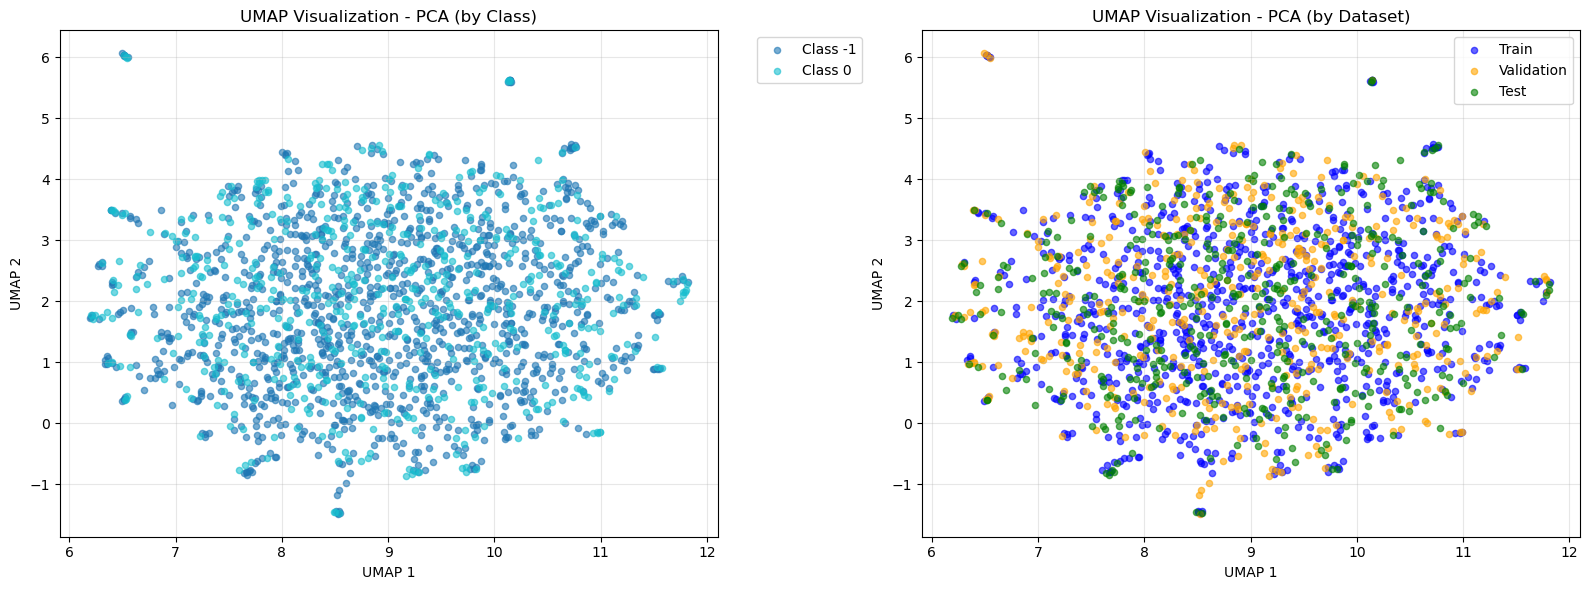

array([[10.079517  ,  0.1153661 ],
       [ 8.123909  ,  2.578933  ],
       [ 9.938049  ,  1.8724409 ],
       ...,
       [ 6.309494  ,  2.6256707 ],
       [ 8.524333  ,  0.12952843],
       [ 8.155977  ,  1.0151417 ]], dtype=float32)

In [13]:
#to plot the umap visualization of the embedding
name='pca'
#to get the umap embedding
plot_umap_embeddings(train_pca, val_pca, test_pca, ny_train, ny_val, ny_test, 'PCA')

In [14]:
#discrete wavelet transform
train_wt, val_wt, test_wt = embd.wavelet_embedding(train_sc, val_sc, test_sc)

c:\Users\alfmi\anaconda3\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [15]:
# Flatten 3D to 2D: (samples, time_steps * features)
train_wt_flat = train_wt.reshape(train_wt.shape[0], -1)
test_wt_flat = test_wt.reshape(test_wt.shape[0], -1)
val_wt_flat = val_wt.reshape(val_wt.shape[0], -1)

# Save flattened versions
np.savetxt('tr_ep_wt_embeddings.txt', train_wt_flat)
np.savetxt('te_ep_wt_embeddings.txt', test_wt_flat)
np.savetxt('vl_ep_wt_embeddings.txt', val_wt_flat)

c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Applying UMAP to 1931 samples with 60 dimensions...


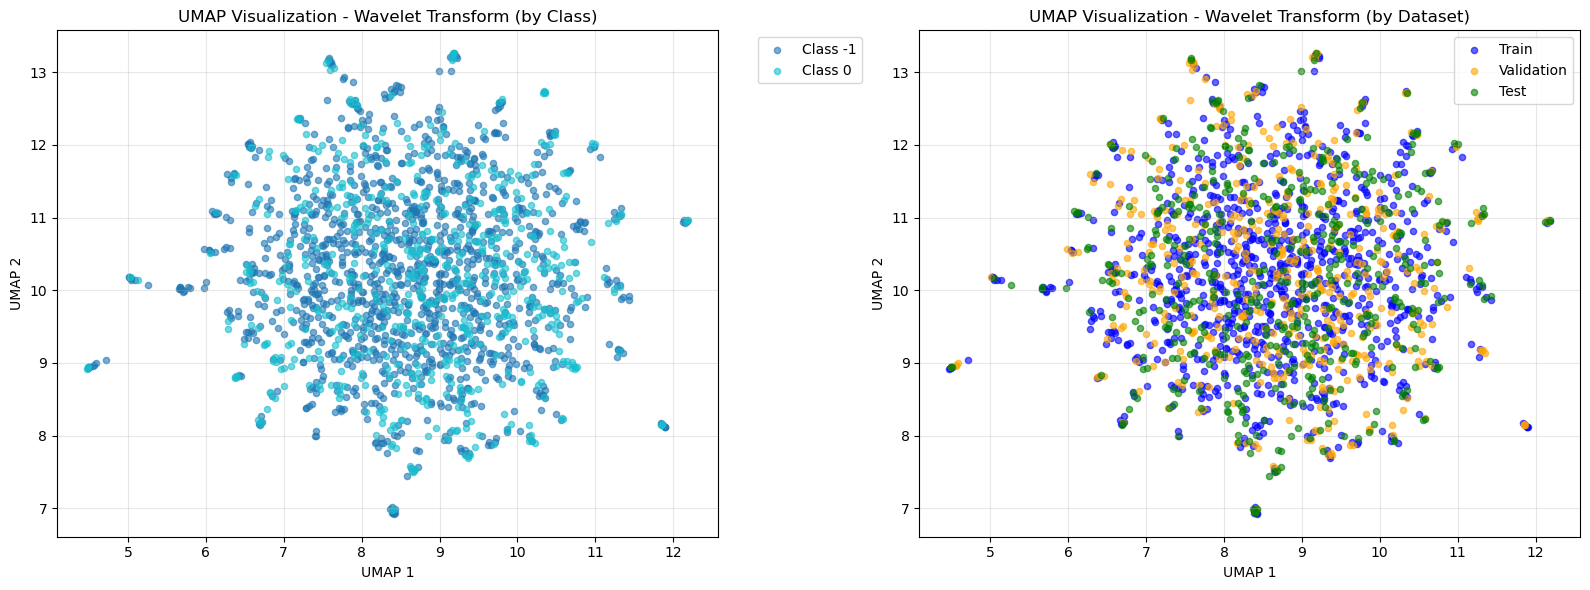

array([[ 8.833685 , 11.887855 ],
       [ 8.005198 , 12.349622 ],
       [ 7.510152 ,  8.82483  ],
       ...,
       [11.334156 , 11.0505905],
       [ 7.4054933,  7.998835 ],
       [ 8.588658 ,  9.252211 ]], dtype=float32)

In [16]:
#to get the umap embedding
plot_umap_embeddings(train_wt_flat, val_wt_flat, test_wt_flat, ny_train, ny_val, ny_test, 'Wavelet Transform')

In [17]:
#Fast Fourier Transform
train_fft, val_fft, test_fft = embd.fft_embedding(train_sc, val_sc, test_sc)

In [18]:
# Flatten 3D to 2D: (samples, time_steps * features)
train_fft_flat = train_fft.reshape(train_fft.shape[0], -1)
test_fft_flat = test_fft.reshape(test_fft.shape[0], -1)
val_fft_flat = val_fft.reshape(val_fft.shape[0], -1)

np.savetxt('tr_ep_fft_embeddings.txt', train_fft_flat)
np.savetxt('te_ep_fft_embeddings.txt', test_fft_flat)
np.savetxt('vl_ep_fft_embeddings.txt', val_fft_flat)

Applying UMAP to 1931 samples with 60 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


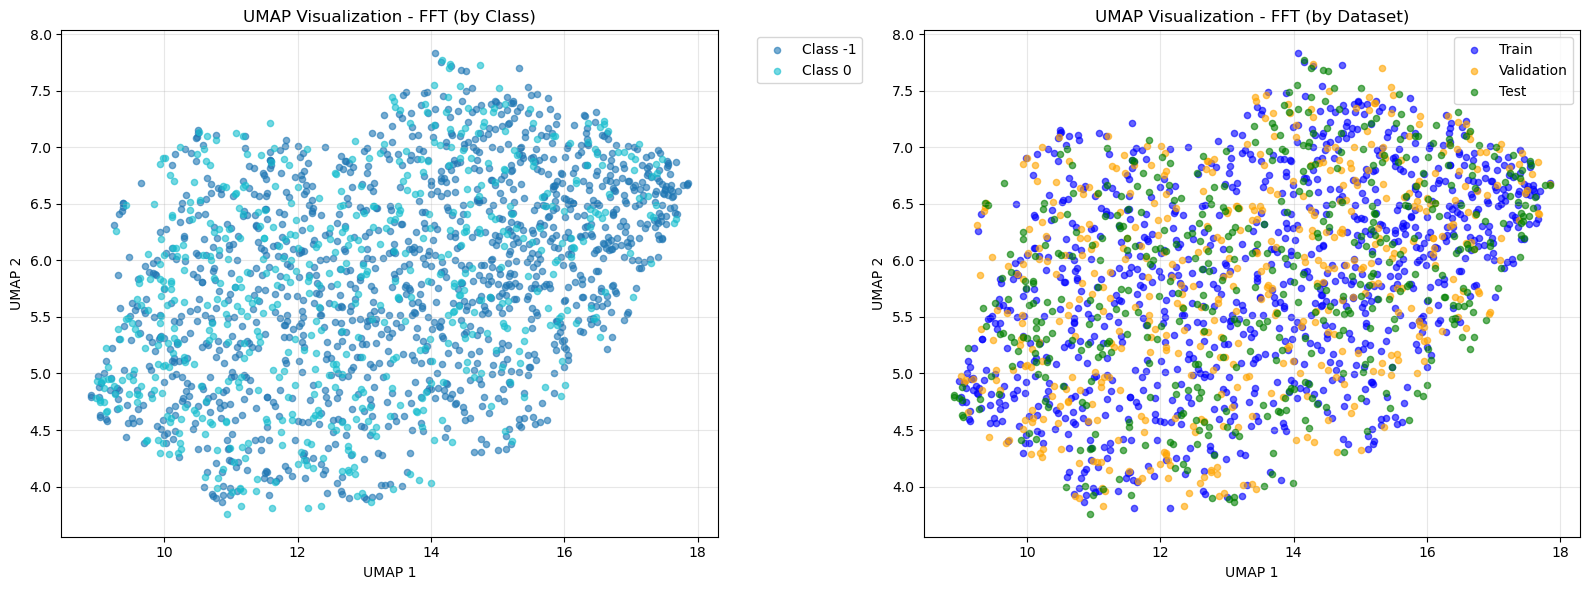

array([[14.154293 ,  6.7252865],
       [12.801875 ,  5.5933924],
       [15.829301 ,  6.6621504],
       ...,
       [10.412478 ,  6.367276 ],
       [10.601999 ,  6.408097 ],
       [10.986039 ,  3.927011 ]], dtype=float32)

In [19]:
#to get the umap embedding
plot_umap_embeddings(train_fft_flat, val_fft_flat, test_fft_flat, ny_train, ny_val, ny_test, 'FFT')

In [20]:
#Graph Embedding

# Convert your scaled data to DataFrames for graph embedding
# First, flatten the 3D data to 2D
train_2d = train_sc.reshape(train_sc.shape[0], -1)
val_2d = val_sc.reshape(val_sc.shape[0], -1)
test_2d = test_sc.reshape(test_sc.shape[0], -1)

# Create DataFrames
X_train_df = pd.DataFrame(train_2d)
X_valid_df = pd.DataFrame(val_2d)
X_test_df = pd.DataFrame(test_2d)


#Based on the source paper and the algorithm discussed, this scaling method is used
train_mmc, val_mmc,test_mmc = embd.minmax_scaling(X_train_df, X_valid_df,X_test_df)
train_mml=train_mmc.values.tolist()
val_mml=val_mmc.values.tolist()
test_mml=test_mmc.values.tolist()

train_gr, val_gr, test_gr = embd.graph_embedding(train_mml, val_mml, test_mml)

In [21]:
np.savetxt('tr_ep_gr_embeddings.txt', train_gr)
np.savetxt('te_ep_gr_embeddings.txt', test_gr)
np.savetxt('vl_ep_gr_embeddings.txt', val_gr)

Applying UMAP to 1931 samples with 23 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


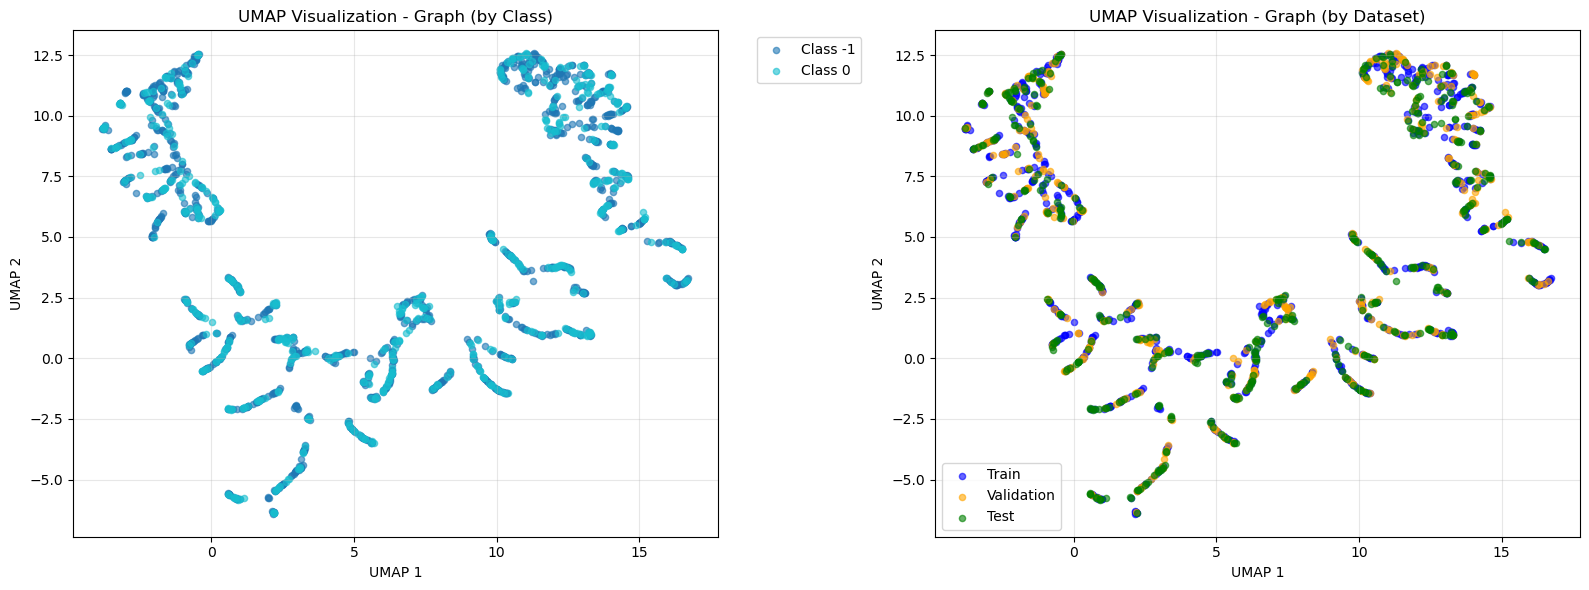

array([[15.677632  ,  4.766572  ],
       [ 8.368678  , -0.5495249 ],
       [-0.29513672,  0.95221716],
       ...,
       [ 1.6730464 , -1.7473179 ],
       [-0.9398276 ,  2.4412034 ],
       [ 0.16524115, -0.1475103 ]], dtype=float32)

In [22]:
#to get the umap embedding
plot_umap_embeddings(train_gr, val_gr, test_gr, ny_train, ny_val, ny_test, 'Graph')

In [23]:
#TDA Embedding
train_tda,val_tda,test_tda = embd.tda_embedding(train_mml, val_mml, test_mml)

In [24]:
np.savetxt('tr_ep_tda_embeddings.txt', train_tda)
np.savetxt('te_ep_tda_embeddings.txt', test_tda)
np.savetxt('vl_ep_tda_embeddings.txt', val_tda)

Applying UMAP to 1931 samples with 49 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


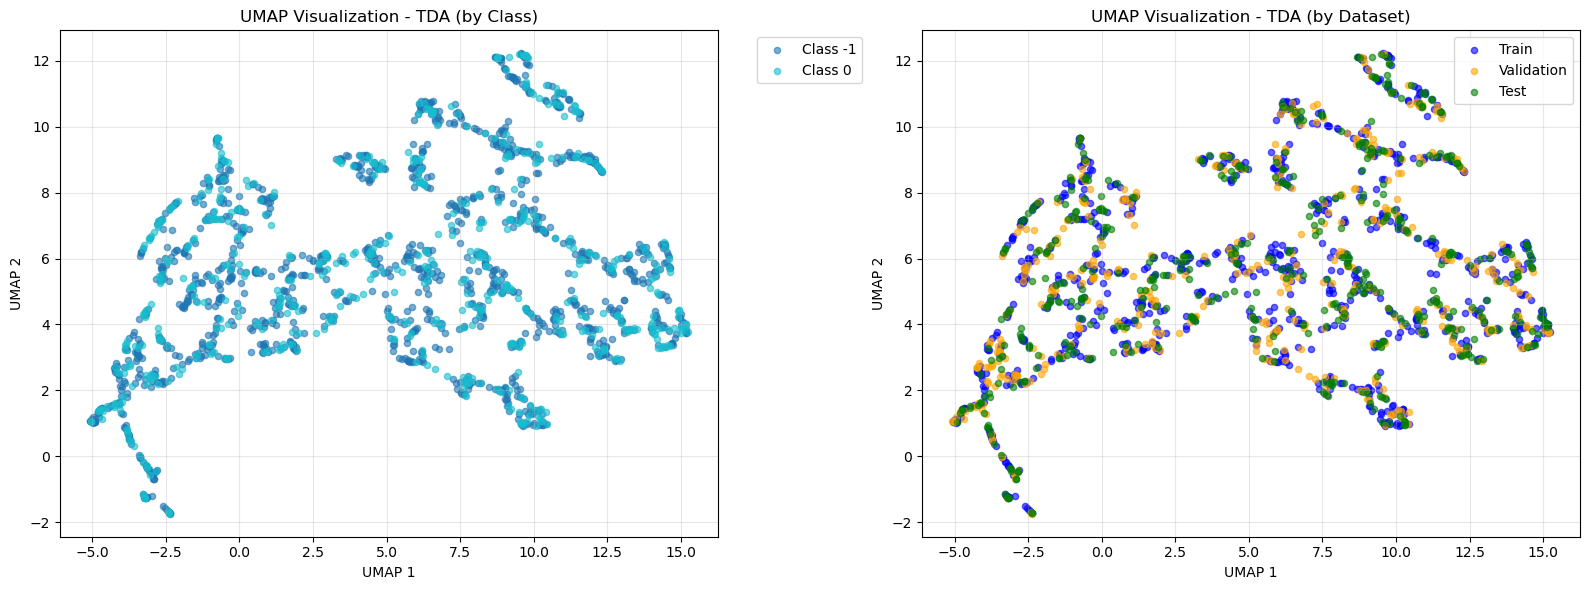

array([[ 8.931628 ,  9.906581 ],
       [ 5.758788 ,  6.3560705],
       [ 1.6860607,  4.622134 ],
       ...,
       [14.10023  ,  5.430911 ],
       [ 8.858191 ,  9.5461235],
       [10.085972 ,  7.21772  ]], dtype=float32)

In [25]:
#to get the umap embedding
plot_umap_embeddings(train_tda,val_tda, test_tda, ny_train, ny_val, ny_test, 'TDA')

In [26]:
# LLE Embedding with dimension checking
train_sc_flat = train_sc.reshape(train_sc.shape[0], -1)
val_sc_flat = val_sc.reshape(val_sc.shape[0], -1)
test_sc_flat = test_sc.reshape(test_sc.shape[0], -1)

print(f"Flattened shapes - Train: {train_sc_flat.shape}, Val: {val_sc_flat.shape}, Test: {test_sc_flat.shape}")

# Check dimensions for LLE constraints
n_samples = train_sc_flat.shape[0]
n_features = train_sc_flat.shape[1]
max_components = min(n_features, n_samples - 1)

print(f"Data info:")
print(f"  Samples: {n_samples}")
print(f"  Features: {n_features}")
print(f"  Max possible components: {max_components}")

# Adjust n_components to be valid
n_components = min(64, max_components)
n_neighbors = min(5, n_samples - 1)

lle_params = {
    'n_components': n_components,
    'n_neighbors': n_neighbors,
    'random_state': 12
}

print(f"Adjusted LLE parameters: {lle_params}")

# LLE Embedding with corrected parameters
train_lle, val_lle, test_lle = embd.lle_embedding(
    train_sc_flat, val_sc_flat, test_sc_flat, lle_params
)



Flattened shapes - Train: (965, 60), Val: (483, 60), Test: (483, 60)
Data info:
  Samples: 965
  Features: 60
  Max possible components: 60
Adjusted LLE parameters: {'n_components': 60, 'n_neighbors': 5, 'random_state': 12}


In [27]:
np.savetxt('tr_ep_lle_embeddings.txt', train_lle)
np.savetxt('te_ep_lle_embeddings.txt', test_lle)
np.savetxt('vl_ep_lle_embeddings.txt', val_lle)

Applying UMAP to 1931 samples with 60 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


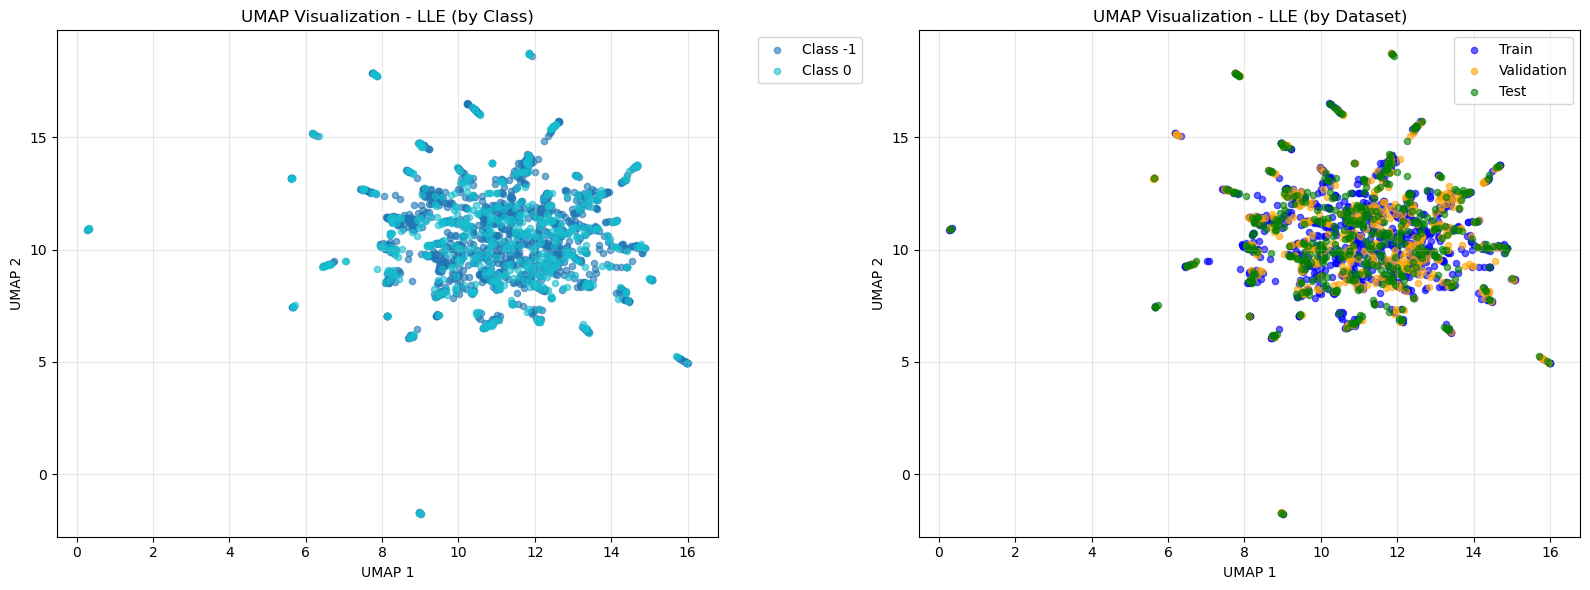

array([[12.03637  ,  8.35499  ],
       [ 9.421563 ,  9.786202 ],
       [12.017908 , 10.322671 ],
       ...,
       [ 7.8534226, 17.736948 ],
       [ 8.192971 ,  8.515763 ],
       [11.316451 , 11.715511 ]], dtype=float32)

In [28]:
plot_umap_embeddings(train_lle, val_lle, test_lle, ny_train, ny_val, ny_test, 'LLE')

In [29]:
#UMAP Embedding
'''train_umap, val_umap, test_umap = embd.umap_embedding(train_sc, val_sc, test_sc)'''




from sklearn.manifold import LocallyLinearEmbedding

def safe_lle_embedding(train_data, val_data, test_data, params):
    """
    Safe LLE embedding with proper error handling
    """
    
    # Ensure all inputs are 2D numpy arrays
    def ensure_2d_numpy(data):
        if hasattr(data, 'numpy'):
            data = data.numpy()
        if len(data.shape) > 2:
            data = data.reshape(data.shape[0], -1)
        return data
    
    train_2d = ensure_2d_numpy(train_data)
    val_2d = ensure_2d_numpy(val_data)
    test_2d = ensure_2d_numpy(test_data)
    
    print(f"Processing LLE with shapes: Train {train_2d.shape}, Val {val_2d.shape}, Test {test_2d.shape}")
    
    # Validate parameters
    n_samples = train_2d.shape[0]
    n_features = train_2d.shape[1]
    
    # Ensure valid parameters
    max_components = min(n_features, n_samples - 1)
    n_components = min(params.get('n_components', 64), max_components)
    n_neighbors = min(params.get('n_neighbors', 5), n_samples - 1)
    
    print(f"Using LLE parameters: n_components={n_components}, n_neighbors={n_neighbors}")
    
    # Create and fit LLE
    lle = LocallyLinearEmbedding(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=params.get('random_state', 42),
        method='standard'
    )
    
    # Fit on training data
    train_lle = lle.fit_transform(train_2d)
    
    # Transform validation and test data
    val_lle = lle.transform(val_2d)
    test_lle = lle.transform(test_2d)
    
    print(f"LLE output shapes: Train {train_lle.shape}, Val {val_lle.shape}, Test {test_lle.shape}")
    
    return train_lle, val_lle, test_lle

# Use the safe implementation
train_sc_flat = train_sc.reshape(train_sc.shape[0], -1)
val_sc_flat = val_sc.reshape(val_sc.shape[0], -1)
test_sc_flat = test_sc.reshape(test_sc.shape[0], -1)

# LLE parameters
n_samples = train_sc_flat.shape[0]
n_features = train_sc_flat.shape[1]
max_components = min(n_features, n_samples - 1)

lle_params = {
    'n_components': min(64, max_components),
    'n_neighbors': min(5, n_samples - 1),
    'random_state': 12
}

print(f"Data info: {n_samples} samples, {n_features} features")
print(f"LLE parameters: {lle_params}")

# Apply safe LLE embedding
train_lle, val_lle, test_lle = safe_lle_embedding(
    train_sc_flat, val_sc_flat, test_sc_flat, lle_params
)

Data info: 965 samples, 60 features
LLE parameters: {'n_components': 60, 'n_neighbors': 5, 'random_state': 12}
Processing LLE with shapes: Train (965, 60), Val (483, 60), Test (483, 60)
Using LLE parameters: n_components=60, n_neighbors=5
LLE output shapes: Train (965, 60), Val (483, 60), Test (483, 60)


In [30]:
np.savetxt('tr_ep_umap_embeddings.txt', train_umap)
np.savetxt('te_ep_umap_embeddings.txt', test_umap)
np.savetxt('vl_ep_umap_embeddings.txt', val_umap)

NameError: name 'train_umap' is not defined

In [ ]:
plot_umap_embeddings(train_sc, val_sc, test_sc, ny_train, ny_val, ny_test, 'Dataset')

Applying UMAP to 1931 samples with 60 dimensions...


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
#AE Embedding
train_ae, val_ae, test_ae = embd.AE_embedding(train_sc, val_sc, test_sc)

c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Applying UMAP to 1931 samples with 4 dimensions...


c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


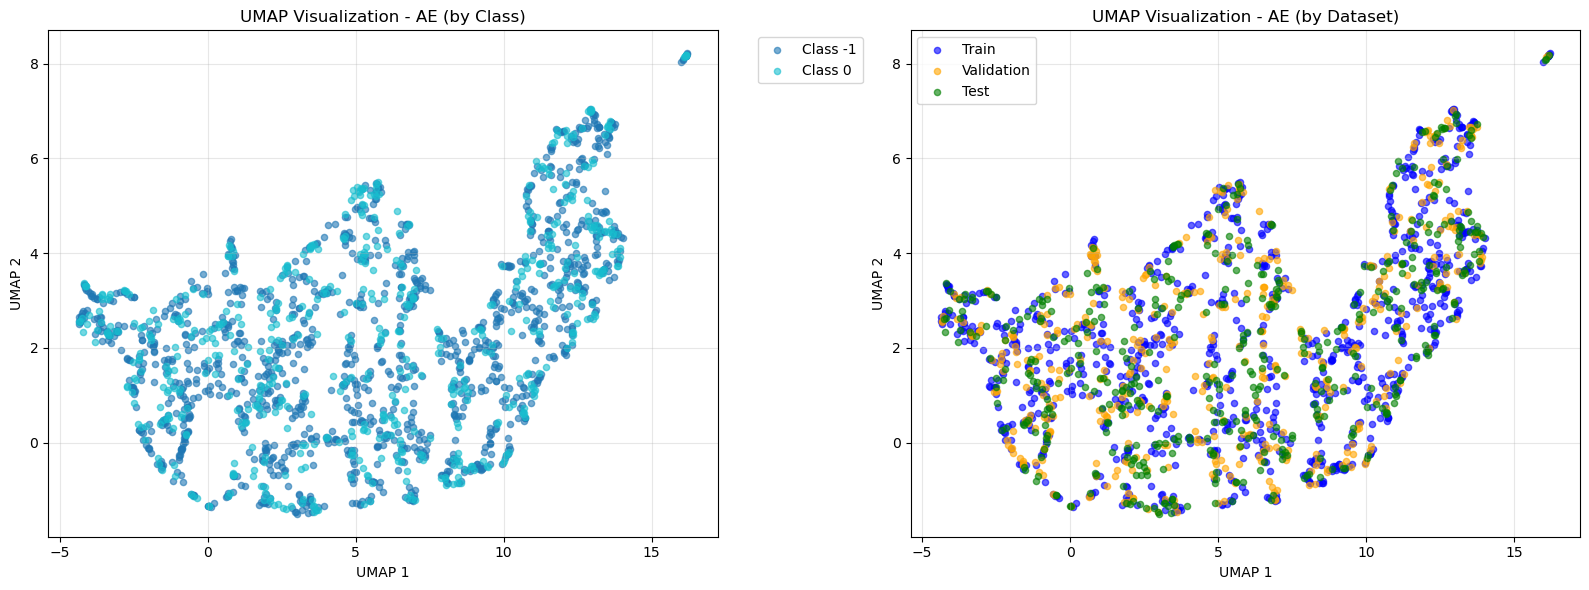

array([[ 4.5849414 ,  1.247422  ],
       [ 0.9311295 ,  3.1950636 ],
       [ 2.5251834 ,  2.0770757 ],
       ...,
       [ 0.8573821 , -0.64273006],
       [-0.95391625,  2.9886782 ],
       [ 1.066589  ,  0.7249451 ]], dtype=float32)

In [ ]:
plot_umap_embeddings(train_ae, val_ae, test_ae, ny_train, ny_val, ny_test, 'AE')

In [ ]:
np.savetxt('tr_ep_ae_embeddings.txt', train_ae)
np.savetxt('te_ep_ae_embeddings.txt', test_ae)
np.savetxt('vl_ep_ae_embeddings.txt', val_ae)

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nnclr_embd (from versions: none)
ERROR: No matching distribution found for nnclr_embd


# Error

In [ ]:
#nnclr_lstm embedding
#for the paper, 100 finetuning and training epochs were chosen, but here the example is done for 20 epochs
#import nnclr_embd as nn
import nnclr_pytorch_embedding as nn
train_nn_lstm, val_nn_lstm, test_nn_lstm = nn.nnclr_lstm_embedding(train_sc, val_sc, test_sc,y_train_df-1,y_valid_df-1,y_test_df-1,64,7)

ModuleNotFoundError: No module named 'cnn_encoder'

In [ ]:
namem="ECG5000_pca"

best_params, best_score = clasfy.optimize_LOGRG(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:49:03,075] A new study created in memory with name: no-name-a90c06a0-b817-495a-92a8-e1971d0cb4a0
[I 2025-04-25 15:49:03,097] Trial 0 finished with value: 0.5 and parameters: {'C': 1.3109715141203191e-05, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.7143156190601682}. Best is trial 0 with value: 0.5.
[I 2025-04-25 15:49:03,114] Trial 1 finished with value: 0.5 and parameters: {'C': 7.275546127089614e-10, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.2635890236189571}. Best is trial 0 with value: 0.5.
[I 2025-04-25 15:49:03,212] Trial 2 finished with value: 0.863013698630137 and parameters: {'C': 0.07152412061986935, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8246182155604214}. Best is trial 2 with value: 0.863013698630137.
[I 2025-04-25 15:49:03,321] Trial 3 finished with value: 0.8561643835616438 and parameters: {'C': 0.09615093567102152, 'fit_intercept': False, 's

0.01563096046447754  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-49-14.txt
{'C': 0.4243058199782983, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.46116238734312126} 0.8571428571428571


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
best_params, best_score = clasfy.optimize_DT(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:49:23,941] A new study created in memory with name: no-name-c14c92a1-93cf-456b-b907-e7c64d5ebed3
[I 2025-04-25 15:49:23,950] Trial 0 finished with value: 0.7602739726027398 and parameters: {'max_depth': 23, 'criterion': 'gini'}. Best is trial 0 with value: 0.7602739726027398.
[I 2025-04-25 15:49:23,958] Trial 1 finished with value: 0.7534246575342466 and parameters: {'max_depth': 29, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7602739726027398.
[I 2025-04-25 15:49:23,966] Trial 2 finished with value: 0.7808219178082192 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7808219178082192.
[I 2025-04-25 15:49:23,972] Trial 3 finished with value: 0.726027397260274 and parameters: {'max_depth': 3, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.7808219178082192.
[I 2025-04-25 15:49:23,980] Trial 4 finished with value: 0.7534246575342466 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 2 with valu

0.0036721229553222656  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-49-25.txt
{'max_depth': 2, 'criterion': 'gini'} 0.8571428571428571


In [ ]:
best_params, best_score = clasfy.optimize_RF(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)

[I 2025-04-25 15:49:45,769] A new study created in memory with name: no-name-6b43ecfb-e187-41b7-a3aa-06e6e5f1c8bd
[I 2025-04-25 15:49:46,062] Trial 0 finished with value: 0.8493150684931506 and parameters: {'n_estimators': 167, 'max_depth': 31}. Best is trial 0 with value: 0.8493150684931506.
[I 2025-04-25 15:49:46,175] Trial 1 finished with value: 0.863013698630137 and parameters: {'n_estimators': 65, 'max_depth': 7}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,197] Trial 2 finished with value: 0.7465753424657534 and parameters: {'n_estimators': 11, 'max_depth': 27}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,410] Trial 3 finished with value: 0.8013698630136986 and parameters: {'n_estimators': 122, 'max_depth': 8}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,701] Trial 4 finished with value: 0.910958904109589 and parameters: {'n_estimators': 188, 'max_depth': 4}. Best is trial 4 with value: 0.91095890410958

0.29011964797973633  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-05.txt
{'n_estimators': 188, 'max_depth': 4} 0.8299319727891157


In [ ]:
best_params, best_score = clasfy.optimize_KNN(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:05,838] A new study created in memory with name: no-name-bd048d5e-1064-4145-bc0b-555a3195715c
[I 2025-04-25 15:50:05,844] Trial 0 finished with value: 0.8561643835616438 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.8561643835616438.
[I 2025-04-25 15:50:05,857] Trial 1 finished with value: 0.8698630136986302 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,909] Trial 2 finished with value: 0.7945205479452054 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,915] Trial 3 finished with value: 0.8493150684931506 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,927] Trial 4 finished with value: 0.8

0.009466886520385742  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-07.txt
{'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree'} 0.8435374149659864


In [ ]:

best_params, best_score = clasfy.optimize_SVM(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:27,062] A new study created in memory with name: no-name-508a74e3-c73e-4b2c-87e4-fd2d20954c4b
[I 2025-04-25 15:50:27,073] Trial 0 finished with value: 0.863013698630137 and parameters: {'C': 0.6, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,213] Trial 1 finished with value: 0.8493150684931506 and parameters: {'C': 0.3, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,353] Trial 2 finished with value: 0.8493150684931506 and parameters: {'C': 0.3, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,361] Trial 3 finished with value: 0.863013698630137 and parameters: {'C': 1, 'kernel': 'rbf', 'degree': 2, 'gamma': 'scale'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,640] Trial 4 finished with value: 0.8493150684931506 and parameters

0.00603485107421875  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-31.txt
{'C': 0.6, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'} 0.8299319727891157


In [ ]:
best_params, best_score = clasfy.optimize_NB(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:44,196] A new study created in memory with name: no-name-461588bc-2622-47fa-8dac-8360215c273b
[I 2025-04-25 15:50:44,201] Trial 0 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 2.038283912389982e-12}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,204] Trial 1 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 5.666967735414902e-08}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,207] Trial 2 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 7.84449094428711e-10}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,210] Trial 3 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 1.1381655658146562e-10}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,214] Trial 4 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 1.3254835312833236e-05}. Best is trial 0 with va

Best hyperparameters:  {'var_smoothing': 0.00926040057010399}
Best validation accuracy:  0.8767123287671232
Test accuracy: 0.8231292517006803
Time taken: 0.002248048782348633 seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-44.txt
{'var_smoothing': 0.00926040057010399} 0.8231292517006803
